<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/DS_440_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [1]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#test comment

In [2]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 74 (delta 37), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (74/74), 1.22 MiB | 7.96 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train-balanced-sarcasm.csv')   # Make sure path is correct in your google drive
train_bal.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
train_bal['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

We can see our dataset is balanced.

In [8]:
train_bal['comment'] = train_bal['comment'].astype('str')
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010826 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [9]:
train_bal[:20]['comment']

0                                            NC and NH.
1     You do know west teams play against west teams...
2     They were underdogs earlier today, but since G...
3     This meme isn't funny none of the "new york ni...
4                       I could use one of those tools.
5     I don't pay attention to her, but as long as s...
6         Trick or treating in general is just weird...
7                       Blade Mastery+Masamune or GTFO!
8     You don't have to, you have a good build, buy ...
9                     I would love to see him at lolla.
10    I think a significant amount would be against ...
11                       Damn I was hoping God was real
12                                 They have an agenda.
13                                          Great idea!
14    Ayy bb wassup, it makes a bit more sense in co...
15                                        what the fuck
16                                               noted.
17    because it's what really bothers him... an

## EDA

In [10]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

In [11]:
# # WordCloud for sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [12]:
# # WordCloud for non-sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [13]:
subreddit_count = sarcastic_com['subreddit'].value_counts()

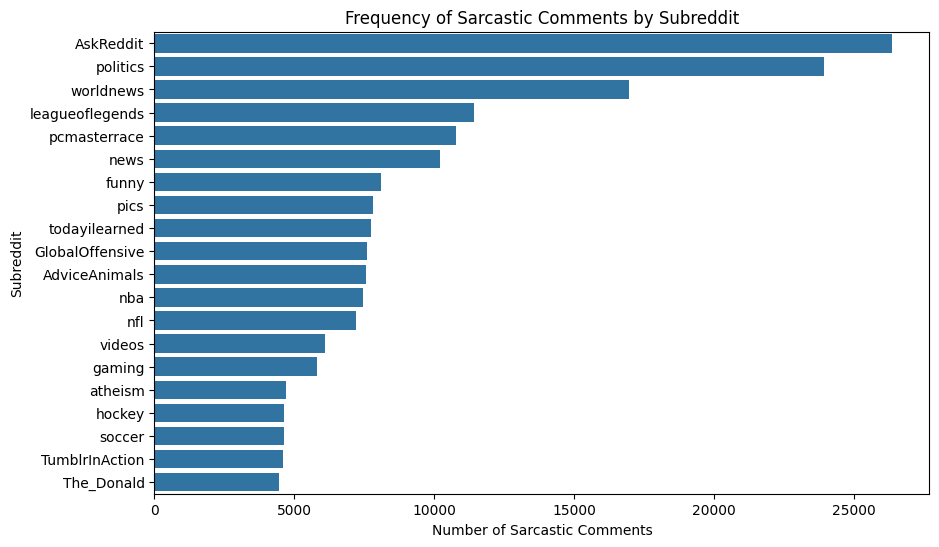

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
top = subreddit_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index)
plt.xlabel('Number of Sarcastic Comments')
plt.ylabel('Subreddit')
plt.title('Frequency of Sarcastic Comments by Subreddit')
plt.show()


In [15]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import spacy # for a lemmatization example

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
comments = train_bal['comment']

In [17]:
comments.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1010826 entries, 0 to 1010825
Series name: comment
Non-Null Count    Dtype 
--------------    ----- 
1010826 non-null  object
dtypes: object(1)
memory usage: 7.7+ MB


In [18]:
comments.dropna(inplace=True)
comments.info()

<class 'pandas.core.series.Series'>
Int64Index: 1010826 entries, 0 to 1010825
Series name: comment
Non-Null Count    Dtype 
--------------    ----- 
1010826 non-null  object
dtypes: object(1)
memory usage: 15.4+ MB


In [19]:
!pip install dask[delayed]

In [20]:
import dask.dataframe as dd
from dask import delayed

In [21]:
comment_test = comments.head(10000)

#Create large function that does this text preprocessing so that it can be used with X_train, also figure out how to split and keep track of data


In [22]:
#  Replace this?
def batch_tokenize(texts, batch_size=50000):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokenized_batch = [word_tokenize(text) for text in batch]
        tokenized_texts.extend(tokenized_batch)
    return tokenized_texts

tokenized_comments = batch_tokenize(comments.tolist())

In [23]:
len(tokenized_comments)

1010826

In [24]:
phrases = Phrases(tokenized_comments)

In [25]:
bigram = Phraser(phrases)

In [26]:
# bigram.phrasegrams

In [27]:
bigram_comments = [bigram[comment] for comment in tokenized_comments]


In [112]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(bigram_comments)
word_index = tokenizer.word_index

# word_index is a dictionary where keys are words and values are their corresponding indices

In [113]:
len(word_index)

284489

In [120]:
word_size = len(word_index) + 1

In [28]:
# Adjust parameters as needed
size = 150
window = 7
min_count = 15
workers = 4
sg = 1
negative = 5
epochs = 7


model = Word2Vec(bigram_comments, vector_size=size, window=window, min_count=min_count, workers=workers)

# model.save("/content/drive/Sarcasm_Data/model/word2vec.w2v")


In [29]:
# model.save("model_embedding.w2v")

In [31]:
# skip re-training the model with the next line:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/word2vec.model')

In [32]:
model.wv['dog']

array([ 0.90451765,  1.7631044 ,  0.6231895 ,  0.777761  , -0.510725  ,
        0.00946851,  0.17777872, -0.10099883, -0.5565152 , -0.7884845 ,
        1.0144794 , -1.570673  , -0.8745102 , -0.4505395 , -0.8160293 ,
        0.13125573, -0.5152664 , -0.22710656,  1.0006125 , -0.6409768 ,
       -1.9435565 ,  1.6426133 , -0.12443724, -0.48832902,  0.6577657 ,
       -0.43018162,  0.74570805, -0.84636575, -0.15677069, -0.789554  ,
       -0.8159635 ,  0.5740654 ,  0.7666069 ,  1.0616834 , -0.3965836 ,
       -0.60506284,  0.3834844 ,  0.34873432,  1.0772258 , -1.2930739 ,
        0.04845177, -0.56659   ,  0.44698796,  1.2523938 , -1.1663436 ,
        0.381793  , -0.8429205 , -1.2329977 , -1.84278   ,  1.4529505 ,
        0.8372087 ,  0.33779916, -1.2361301 ,  1.4015558 ,  1.5104085 ,
        1.559361  ,  1.278143  , -0.06229809,  0.8317676 , -0.65179724,
        1.0235895 ,  0.48910755,  1.1788733 , -1.1857599 , -0.22784023,
        0.41432002,  0.41276404, -0.01175862,  0.4518781 , -0.73

In [33]:
similar_words = model.wv.most_similar('ok')
similar_words

[('okay', 0.9446449279785156),
 ('OK', 0.9253052473068237),
 ('alright', 0.7982171773910522),
 ('fine', 0.6672182083129883),
 ('perfectly_fine', 0.642020046710968),
 ('cool', 0.5878971815109253),
 ('justified', 0.5626591444015503),
 ('wrong', 0.5318138599395752),
 ('understandable', 0.5288909077644348),
 ('unacceptable', 0.4947114884853363)]

In [34]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [35]:
model.wv.similarity('father', 'dog')

0.66480863

In [36]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])   # Should expect mother

[('mother', 0.7413758039474487),
 ('child', 0.709227979183197),
 ('daughter', 0.6811947822570801),
 ('wife', 0.6779746413230896),
 ('husband', 0.6702209115028381),
 ('sister', 0.6224682927131653),
 ('girlfriend', 0.6099835634231567),
 ('family', 0.606359601020813),
 ('teacher', 0.5988774299621582),
 ('family_member', 0.5981861352920532)]

In [37]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])  # Should expect wife

[('daughter', 0.7059494853019714),
 ('mother', 0.6991272568702698),
 ('child', 0.6818873882293701),
 ('partner', 0.6637686491012573),
 ('wife', 0.6501094698905945),
 ('girlfriend', 0.6445956230163574),
 ('father', 0.6311219334602356),
 ('boyfriend', 0.6283386945724487),
 ('sister', 0.6098517775535583),
 ('penis', 0.609626293182373)]

### t-SNE Word Embedding Visualization

In [41]:
tsne = TSNE(n_components=2, n_iter=1000)

In [42]:
X_2d = tsne.fit_transform(model.wv[model.wv.key_to_index])
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.index_to_key
coords_df.head()


OSError: Cannot save file into a non-existent directory: '/content/drive/Sarcasm_Data/model'

In [47]:
coords_df.to_csv("/content/drive/MyDrive/Sarcasm_Data/coords_df", index=False)

In [49]:
coords_df = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/coords_df')
output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(min_width=800, min_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)
show(p)

# Start LSTM architecture with these initial embeddings before BERT


# Need to create embeddings matrix for LSTM


In [52]:
train_bal.dropna(inplace=True)

In [53]:
train_bal.shape[0]

1010826

In [90]:
train_bal.tail(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...


In [78]:
from sklearn.model_selection import train_test_split
# split the dataset into 60% training and 40% validation and test sets
train_df, val_test_df = train_test_split(train_bal, test_size=0.4, random_state=42)

# split the 40% into half validation and half test sets
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [127]:
X_train = train_df['comment']
y_train = train_df['label']

In [79]:
word2vec = Word2Vec.load("/content/drive/MyDrive/word2vec.model")


In [121]:
#extracting pretrained weights for embedding layer using word2vec model
word_vectors = word2vec.wv


In [122]:
vector_size = model.vector_size
vector_size

150

In [123]:
#inititlze embeddings matrix
import numpy as np
embedding_matrix = np.zeros((word_size, vector_size))

In [124]:
#fill embeddings matrix for LSTM with tensor flow : each row should correspond to a word
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [125]:
embedding_df = pd.DataFrame(embedding_matrix)

In [126]:
embedding_df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
284485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = Sequential()
model.add(Embedding(input_dim=word_size, output_dim=word2vec.vector_size, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# get X_train data into format where the embeddings layer can look up its corresposnding vector, add padding so that all input is the same length
# model.evaluate(X_test, y_test)


Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node sequential/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-128-7c9bc7fbb5bf>", line 19, in <cell line: 19>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 654, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 751, in _conform_to_reference_input

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to float is not supported
	 [[{{node sequential/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3128]